<a href="https://colab.research.google.com/github/bigdata210/Python/blob/main/Python%20basis/pytorch%26sklearn_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글폰트 에러현상해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import matplotlib as mpl
print("버전:",mpl.__version__)
print("설치위치:", mpl.__file__)
print("설정위치:",mpl.get_configdir())
print("캐시위치:",mpl.get_cachedir())
print("설정파일위치:",mpl.matplotlib_fname())

버전: 3.7.1
설치위치: /usr/local/lib/python3.9/dist-packages/matplotlib/__init__.py
설정위치: /root/.config/matplotlib
캐시위치: /root/.cache/matplotlib
설정파일위치: /usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc


# skorch
: sklearn + pytorch
- grid search 등을 함께 사용가능

sklearn pipeline
- 데이터 전처리에서 발생하는 불확실성 줄여줌.
- 실수를 사전에 예방
- trainset 정보를 기억해서 testset에 적용하기 좋음.


In [ ]:
# 펭귄 데이터셋 이용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# 시각화 설정
sns.set_context("talk")
sns.set_style("white")
font_title={"color":"gray"}

# Linux 한글 사용 설정
plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 펭귄 데이터셋 불러오기
df_peng = sns.load_dataset("penguins")
# 결측치 제거 후 데이터 확인
df_peng.dropna(inplace=True)
df_peng.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [ ]:
y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)
X.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,Adelie,Torgersen,39.1,18.7,181.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,Female


In [ ]:
# data train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## pipeline 구축
- numerical feature 
  + PolynomialFeatures(회귀모델 적용 고려)
  + RobustScaler(데이터 정규화)
  <br/>

- categorical feature 
  + OneHotEncoder

In [ ]:
# encoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [ ]:
# pipeline 구축하는 함수 생성
def get_model_0(X_cols, degree=1, method="lr"):
  X_cols = deepcopy(X_cols)

  # 1-1.categorical feature에 one_hot encoding 적용
  cat_features = list(set(X_cols) & set(["species", "island", "sex"]))
  cat_transformer = OneHotEncoder(sparse=False, handle_unknown ="ignore")

  # 1-2. numerical feature는 Power Transform과 Scaler를 거침
  num_features = list(set(X_cols) - set(cat_features))
  num_features.sort()
  num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                    ("scaler", RobustScaler())
                                    ])
  
  # 1. 인자 종류별 전처리 적용
  preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                                 ("cat", cat_transformer, cat_features)])
  
  # 2. 전처리 후 머신러닝 모델 적용
  if method == "lr":
    ml = LinearRegression(fit_intercept=True)
  elif method == "rf":
    ml = RandomForestRegressor()

  # 3. Pipeline
  model = Pipeline(steps=[("preprocessor", preprocessor),
                          ("ml", ml)])
  
  return model

In [ ]:
from sklearn import set_config
set_config(display="diagram")
model_0 = get_model_0(list(X_train.columns), degree=1, method="lr")
model_0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'sex',
                                                   'species'])])),
                ('ml', LinearRegression())])

## pipeline 전처리 확인
- 전처리 모듈 모델이름["모듈이름"]

In [ ]:
X_train_pp = model_0["preprocessor"].fit_transform(X_train)
print(X_train_pp.shape)
X_train_pp[0]

(266, 12)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([ 0.        ,  0.70967742, -0.32869081, -0.02105263,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ])

- 처음의 0 : LinearRegression에서 만든 intercept 항
- 네번째 0.82부터는 species, island, sex의 one-hot encoding 결과

## 시각화해보기
- 데이터 분포도 확인



Text(0.5, 0.98, '')

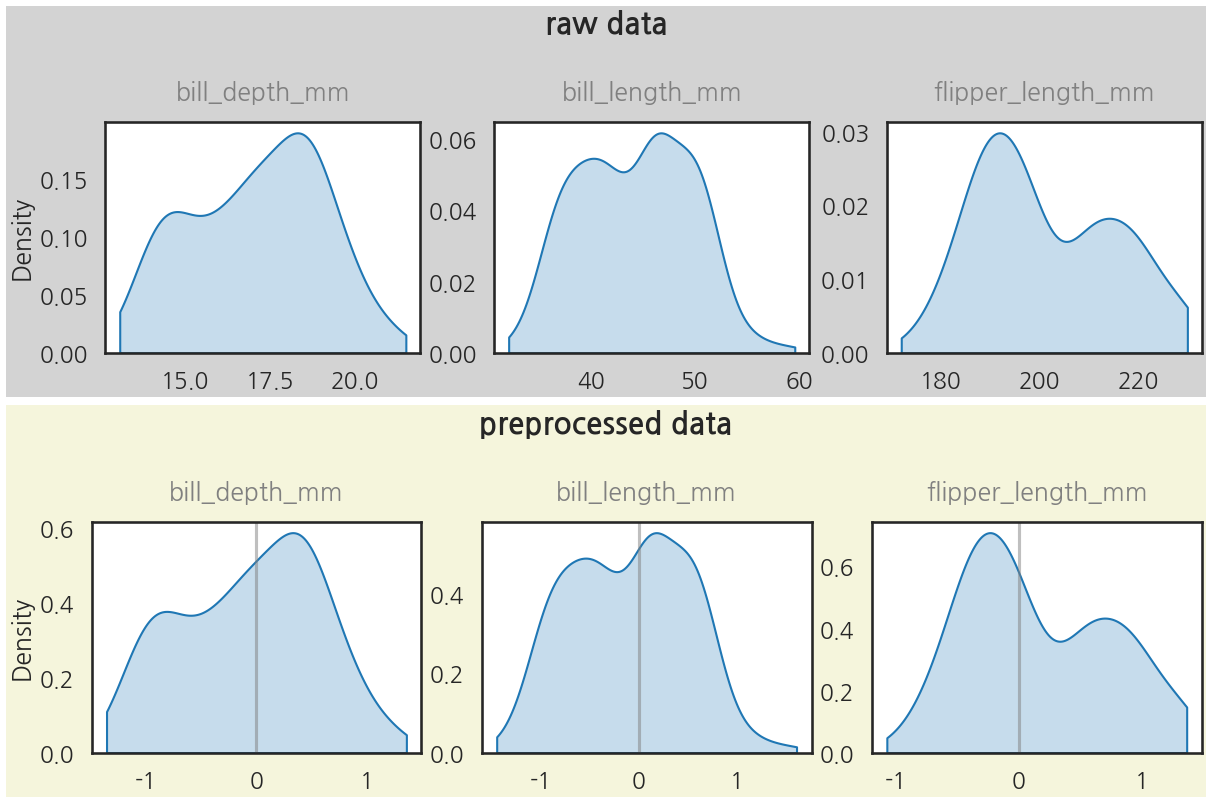

In [ ]:
# Figure 생성
fig = plt.figure(figsize=(12,8), constrained_layout=True)

# Subfigures 생성
subfigs = fig.subfigures(nrows=2, wspace=0.05)
subfigs[0].set_facecolor("lightgray")
subfigs[1].set_facecolor("beige")

# subfigs[0]: raw data
axs0 = subfigs[0].subplots(ncols=3, nrows=1)

sns.kdeplot(X_train["bill_depth_mm"], cut=0, fill=True, ax=axs0[0])
sns.kdeplot(X_train["bill_length_mm"], cut=0, fill=True, ax=axs0[1])
sns.kdeplot(X_train["flipper_length_mm"], cut=0, fill=True, ax=axs0[2])

# subfigs[1]: preprocessed data
axs1 = subfigs[1].subplots(ncols=3, nrows=1)

sns.kdeplot(X_train_pp[:,1], cut=0, fill=True, ax=axs1[0])
sns.kdeplot(X_train_pp[:,2], cut=0, fill=True, ax=axs1[1])
sns.kdeplot(X_train_pp[:,3], cut=0, fill=True, ax=axs1[2])

for ax in axs1:
  ax.axvline(0, c="gray", alpha=0.5)

for axs in [axs0, axs1]:
  for i, (ax, title) in enumerate(zip(axs, ['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm'])):
    ax.set_xlabel("")
    ax.set_title(f"{title}", fontdict=font_title, pad=16)
    if i > 0:
      ax.set_ylabel("\n")

subfigs[0].suptitle("raw data\n", fontweight="bold")
subfigs[1].suptitle("preprocessed data\n", fontweight="bold")
fig.suptitle("")      

## pipeline 학습


In [ ]:
model_0.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'sex',
                                                   'species'])])),
                ('ml', LinearRegression())])

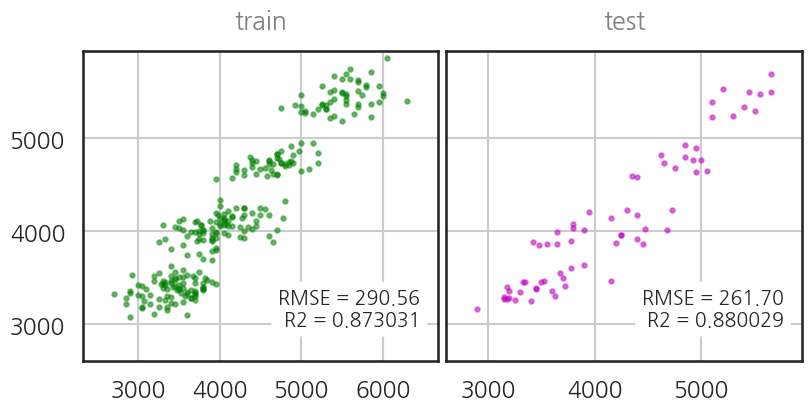

In [ ]:
# parity plot
def plot_parity(model, y_true, y_pred=None, X_to_pred=None, ax=None, **kwargs):
  if not ax:
    fig, ax = plt.subplots(figsize=(5,5))

  if y_pred is None:
      y_pred = model.predict(X_to_pred)
  ax.scatter(y_true, y_pred, **kwargs)
  xbound = ax.get_xbound()
  xticks = [x for x in ax.get_xticks() if xbound[0] <= x <= xbound[1]]
  ax.set_xticks(xticks) 
  ax.set_xticklabels([f"{x:.0f}" for x in xticks])
  ax.set_yticks(xticks)
  ax.set_yticklabels([f"{x:.0f}" for x in xticks])
  dxbound = 0.05*(xbound[1]-xbound[0])
  ax.set_xlim(xbound[0]-dxbound, xbound[1]+dxbound)
  ax.set_ylim(xbound[0]-dxbound, xbound[1]+dxbound)

  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r2 =r2_score(y_true, y_pred)
  ax.text(0.95, 0.1, f"RMSE = {rmse:.2f}\nR2 = {r2:2f}", transform=ax.transAxes,
  fontsize=14, ha="right", va="bottom", bbox={"boxstyle":"round", "fc":"w", "pad":0.3})

  ax.grid(True)

  return ax

fig, axs = plt.subplots(ncols=2, figsize=(8,4), constrained_layout=True, sharey=True)
plot_parity(model_0, y_train, X_to_pred=X_train, ax=axs[0], c="g", s=10, alpha=0.5)
plot_parity(model_0, y_test, X_to_pred=X_test, ax=axs[1], c="m", s=10, alpha=0.5)

for ax, title in zip(axs, ["train","test"]):
  ax.set_title(title, fontdict=font_title, pad=16)

In [ ]:
model_1 =get_model_0(list(X_train.columns), degree=1, method="rf")
model_1.fit(X_train, y_train)
model_1

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'sex',
                                                   'species'])])),
                ('ml', RandomForestRegressor())])

In [ ]:
model_2 = get_model_0(["bill_length_mm","species"], degree=1, method="rf")
model_2.fit(X_train, y_train)
model_2

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['species'])])),
                ('ml', RandomForestRegressor())])

# pytorch deep learning
- 딥러닝은 다른 방법에 비해 복잡하고 연산자원이 많이 듦.

## pytorch only

In [ ]:
from torch import optim
from torch.optim.lr_scheduler import CyclicLR

import torch
import torch.nn as nn

class RegressorModule(nn.Module):
  def __init__(self, ninput=11, init_weights=True):
    super(RegressorModule, self).__init__()

    self.model = nn.Sequential(nn.Linear(ninput, 16),
                               nn.ReLU(),
                               nn.Linear(16,16),
                               nn.ReLU(),
                               nn.Linear(16,12),
                               nn.ReLU(),
                               nn.Linear(12,8),
                               nn.ReLU(),
                               nn.Linear(8,1),
                               )
    if init_weights:
      self._initialize_weights()

  def forward(self, X, **kwargs):
      return self.model(X)

  def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, 0, 0.01)
          nn.init.constant_(m.bias, 0)


In [ ]:
X_train_tensor = torch.Tensor(pd.get_dummies(X_train).astype(np.float32).values)
y_train_tensor = torch.Tensor(y_train.astype(np.float32).values)

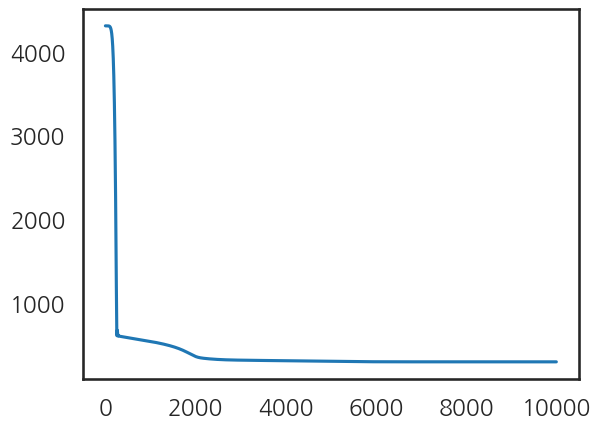

In [ ]:
net = RegressorModule()

class RMSELoss(nn.Module):
  def __init__(self, eps=1e-6):
    super().__init__()
    self.mse = nn.MSELoss()
    self.eps = eps

  def forward(self,yhat,y):
    loss = torch.sqrt(self.mse(yhat,y)+ self.eps)
    return loss

loss_func = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

losses =[]
for i in range(10000):
    optimizer.zero_grad()
    output = net.forward(X_train_tensor)
    loss = loss_func(output, y_train_tensor.view(-1,1))
    loss.backward()
    optimizer.step()

    losses.append(loss)

plt.plot([x.detach().numpy() for x in losses])

In [ ]:
# numpy array를 pytorch tensor로 변환
X_test_tensor = torch.Tensor(pd.get_dummies(X_test).astype(np.float32).values)

# 예측값
y_pred_train_tensor = net.forward(X_train_tensor)
y_pred_test_tensor = net.forward(X_test_tensor)

# pytorch tensor를 다시 numpy array로 변환
y_pred_train = y_pred_train_tensor.detach().numpy()
y_pted_test = y_pred_test_tensor.detach().numpy()

### pytorch @pipeline
- skorch를 이용해서 pytorch를 pipeline 안에 탑재
- skorch은 pytorch를 scikit-learn 객체처럼 만들어주는 일

In [ ]:
pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 14.5 MB/s eta 0:00:00


In [ ]:
from skorch import NeuralNetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

def get_model_T(X_cols, degree=1, method="lr"):
    
    X_cols_ = deepcopy(X_cols)
    
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_features = list(set(X_cols) & set(["species", "island", "sex"]))
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # 1-2.numerical feature는 Power Transform과 Scaler를 거침
    num_features = list(set(X_cols) - set(cat_features))
    num_features.sort()
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)), 
                                      ("scaler", RobustScaler())
                                     ])

    # 1. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features), 
                                                   ("cat", cat_transformer, cat_features)])
    
    # 2. float64를 float32로 변환
    class FloatTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass
        def fit(self, X, y=None):
            return self
        def transform(self, x):
            return np.array(x, dtype=np.float32)
    
    # 3. 전처리 후 머신러닝 모델 적용
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor()
    elif method == "torch":
        ninput = len(num_features) + 1
        if "species" in cat_features:
            ninput += 3
        if "island" in cat_features:
            ninput += 3
        if "sex" in cat_features:
            ninput += 2
            
        net = NeuralNetRegressor(RegressorModule(ninput=ninput, init_weights=False),
                         max_epochs=1000, verbose=0,
                         warm_start=True,
#                          device='cuda',
                         criterion=RMSELoss,
                         optimizer = optim.Adam,
                         optimizer__lr = 0.01
                        )
        ml = net

        
    # 3. Pipeline
    model = Pipeline(steps=[("preprocessor", preprocessor), 
                            ("float64to32", FloatTransformer()),
                            ("ml", ml)])
    
    return model

In [ ]:
model_T = get_model_T(list(X_train.columns), degree=1, method="torch")
model_T.fit(X_train, y_train.astype(np.float32).values.reshape(-1,1))
model_T

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['island', 'sex',
                                                   'species'])])),
                ('float64to32', FloatTransformer()),
                ('ml',
                 <cla...d](
  module_=RegressorModule(
    (model): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=12, bias=True)
      (5): ReLU()
      (6): Linear(in_features=12, out_features=8, bias=True)
      (7): ReLU()
      (8): Linear(in_features=8, out_features=1, bias=True)
    )
  ),
))])

## permutation feature importance
- 각각의 인자 중요도를 확인

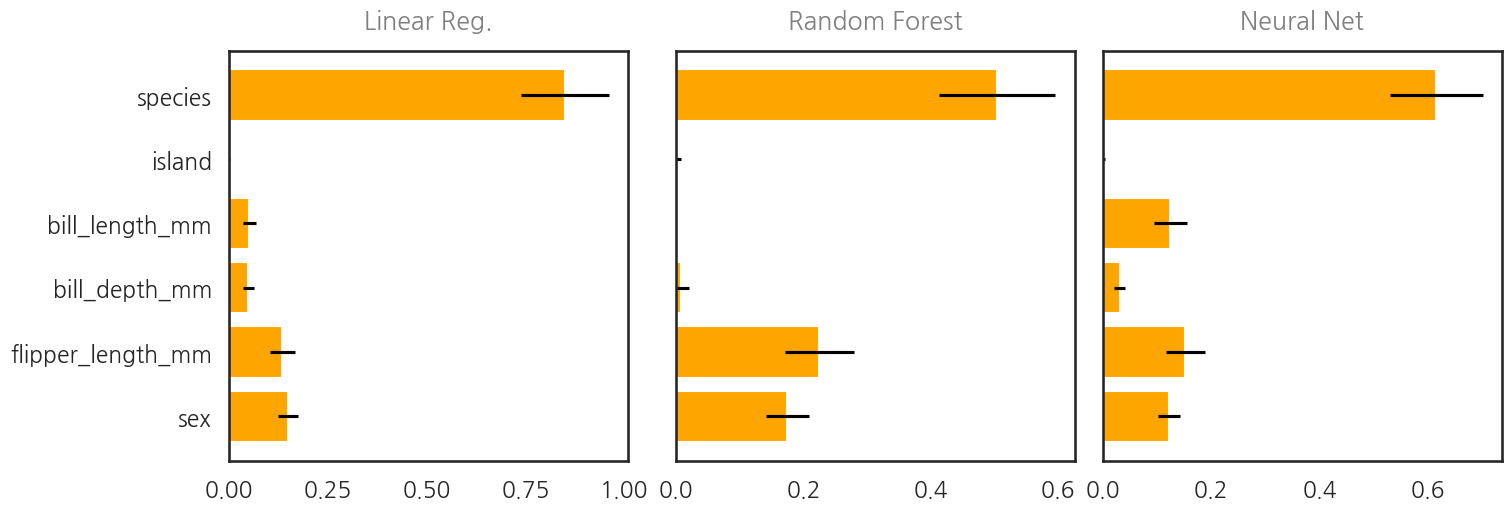

In [ ]:
from sklearn import model_selection
from sklearn.inspection import permutation_importance

# Linear Regression
pi_0 = permutation_importance(model_0, X_test, y_test, n_repeats=30, random_state=0 )

# Random Forest
pi_1 = permutation_importance(model_1, X_test, y_test, n_repeats=30, random_state=0 )

# Neural Network
pi_T = permutation_importance(model_T, X_test, y_test, n_repeats=30, random_state=0 )

# 시각화
fig, axs = plt.subplots(ncols=3, figsize=(15,5), constrained_layout=True, sharey=True)

for ax, pi, title in zip(axs, [pi_0, pi_1, pi_T], ["Linear Reg.", "Random Forest", "Neural Net"]):
    ax.barh(X_test.columns, pi.importances_mean, xerr = pi.importances_std, color="orange")
    ax.invert_yaxis()
    ax.set_xlim(0, )
    ax.set_title(title, fontdict=font_title, pad=16)